In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random
from datetime import datetime
import pytz

# importo los .py
import sys
sys.path.append("auxiliares")
import config
import metricas
import lightgbm_aux
import extras

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_producto_transf_fe.csv"

arch_min_max_prod = "datasets/emp3_min_max_prod.csv"
arch_mean_std_prod = "datasets/emp3_mean_std_prod.csv"

carpeta_exp_prefijo = "exp/intermedia_2/"

In [4]:
GLOBAL_PRODUCT_IDS = pd.DataFrame() #aca solamente se define, se setea mas abajo

In [5]:
########### NORMALIZACION
def normalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        if (maximo-minimo)==0: 
            return 0
        else:
            return (valor - minimo) / (maximo-minimo)

        
def desnormalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        return (valor * (maximo-minimo)) + minimo

In [6]:
############# ESTANDARIZACION
def estandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        if desvio==0: 
            return 0
        else:
            return (valor - media) / desvio

def desestandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        return (valor * desvio) + media

In [7]:
################### TRANSFORMACION    
def transformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return normalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return estandarizar_valor(valor,var1,var2)

def destransformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return desnormalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return desestandarizar_valor(valor,var1,var2)

In [8]:
############ DEFINO Vector Global de Productos #################
def actualizar_global_prods(prod_values, y_vector):
    
    GLOBAL_PRODUCT_IDS = pd.DataFrame(data={"product_id":prod_values, "tn":np.array(y_vector)})
    GLOBAL_PRODUCT_IDS = GLOBAL_PRODUCT_IDS.merge(df_prod_val1_val2,how="left",on="product_id")
    GLOBAL_PRODUCT_IDS = GLOBAL_PRODUCT_IDS.sort_values(by="product_id",ascending=True)
    
    return GLOBAL_PRODUCT_IDS

In [9]:
def error_rate(y, y_pred):
    y_pred = np.array(y_pred)
    
    #Destransformo
    df_calculo = GLOBAL_PRODUCT_IDS.copy()
    df_calculo["y"] = y
    df_calculo["y_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y"],row["valor_1"],row["valor_2"]),axis=1)

    df_calculo["y_pred"] = y_pred
    df_calculo["y_pred_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y_pred"],row["valor_1"],row["valor_2"]),axis=1)

    y = df_calculo.y_destransformado
    y_pred = df_calculo.y_pred_destransformado
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(labels,preds)
    return 'ER', ret_val, False

In [10]:
def destransformar_vector(y_vector):
    df_calculo = GLOBAL_PRODUCT_IDS.copy()
    df_calculo["y"] = y_vector
    df_calculo["y_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y"],row["valor_1"],row["valor_2"]),axis=1)

    return df_calculo.y_destransformado

In [11]:
def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = metricas.error_rate(labels,preds)
    return 'ER', ret_val, False

In [12]:
def objective(trial):
    print("****************", config.OBJECTIVE_PARAM, "****************")
    
    lgb_params = {
        'objective': config.OBJECTIVE_PARAM,
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0,config.L1_UPPER_PARAM),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0,config.L2_UPPER_PARAM),
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': config.MAX_BIN_PARAM,
        'learning_rate': trial.suggest_uniform('learning_rate', config.LEARNING_RATE_LOWER_PARAM,config.LEARNING_RATE_UPPER_PARAM ),
        'num_leaves' : trial.suggest_int('num_leaves', config.NUM_LEAVES_LOWER_PARAM, config.NUM_LEAVES_UPPER_PARAM),
        'feature_fraction': trial.suggest_uniform('feature_fraction', config.FEATURE_FRACTION_LOWER_PARAM, config.FEATURE_FRACTION_UPPER_PARAM),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', config.MIN_DATA_IN_LEAF_LOWER_PARAM, config.MIN_DATA_IN_LEAF_UPPER_PARAM),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols_entren)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols_entren)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = metricas.error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [13]:
##############################################

In [14]:
df_sellout = pd.read_csv(arch_entrada)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 86 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   product_id                   34707 non-null  int64  
 1   periodo                      34707 non-null  int64  
 2   tn                           34707 non-null  float64
 3   cero_ventas                  34707 non-null  int64  
 4   cust_request_qty             34707 non-null  float64
 5   cust_request_tn              34707 non-null  float64
 6   mes                          34707 non-null  int64  
 7   producto_estrella            34707 non-null  float64
 8   plan_precios_cuidados        34707 non-null  float64
 9   meses_historia_prod          34707 non-null  int64  
 10  cat1                         34707 non-null  object 
 11  cat2                         34707 non-null  object 
 12  cat3                         34707 non-null  object 
 13  sku_size        

In [15]:
df_prods_prediccion_entren=pd.read_csv(config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO)
df_prods_prediccion_entren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   product_id  780 non-null    int64
dtypes: int64(1)
memory usage: 6.2 KB


In [16]:
### Categoricas
df_sellout = extras.convertir_categoricas_prod(df_sellout)

In [17]:
### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_validate = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.VALIDATE_PERIODO_PARAM)]

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_validate.periodo.unique())

df_validate = df_validate.sort_values(by="product_id",ascending=True)
print("product_id a validar:", len(df_validate))

Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905]
Periodos validar: [201907]
product_id a validar: 756


In [18]:
### Armado variables entrenamiento
cols_remover_entren = ["tn_mas_2","periodo"]

# Train - Validate
X_train = df_train.drop(columns=cols_remover_entren, axis=1)
X_validate = df_validate.drop(columns=cols_remover_entren, axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

cols_entren = X_train.columns.tolist()

X_train: (27519, 84)
y_train: (27519,)

X_validate: (756, 84)
y_validate: (756,)


In [19]:
# Dataframes auxiliares
if config.TIPO_TRANSF_PARAM == "normalizacion":
    print("Normalizacion")
    df_prod_val1_val2 = pd.read_csv(arch_min_max_prod)

elif config.TIPO_TRANSF_PARAM == "estandarizacion":
    print("Estandarizacion")
    df_prod_val1_val2 = pd.read_csv(arch_mean_std_prod)

Normalizacion


In [20]:
#Antes de entrenar, se setea vector global para validate
GLOBAL_PRODUCT_IDS = actualizar_global_prods(X_validate.product_id,y_validate)

### Optimizacion Bayesiana
GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=config.CANT_ITERACIONES_OPT_BAY_PARAM)
print('# Experimentos:', len(study.trials))
print('Mejor experimento:', study.best_trial.params)

[I 2023-12-15 22:33:17,975] A new study created in memory with name: no-name-2f339145-3c0e-4ab7-91ae-8b47a4ddc2bd


**************** regression_l1 ****************
Training until validation scores don't improve for 87 rounds
[100]	valid_0's ER: 72.32


[I 2023-12-15 22:34:08,098] Trial 0 finished with value: 72.21 and parameters: {'lambda_l1': 453.60250934754134, 'lambda_l2': 992.9521090806066, 'learning_rate': 0.1344440344651144, 'num_leaves': 980, 'feature_fraction': 0.41726093624936206, 'min_data_in_leaf': 7056}. Best is trial 0 with value: 72.21.


Early stopping, best iteration is:
[91]	valid_0's ER: 72.21
Evaluated only: ER
# Experimentos: 1
Mejor experimento: {'lambda_l1': 453.60250934754134, 'lambda_l2': 992.9521090806066, 'learning_rate': 0.1344440344651144, 'num_leaves': 980, 'feature_fraction': 0.41726093624936206, 'min_data_in_leaf': 7056}


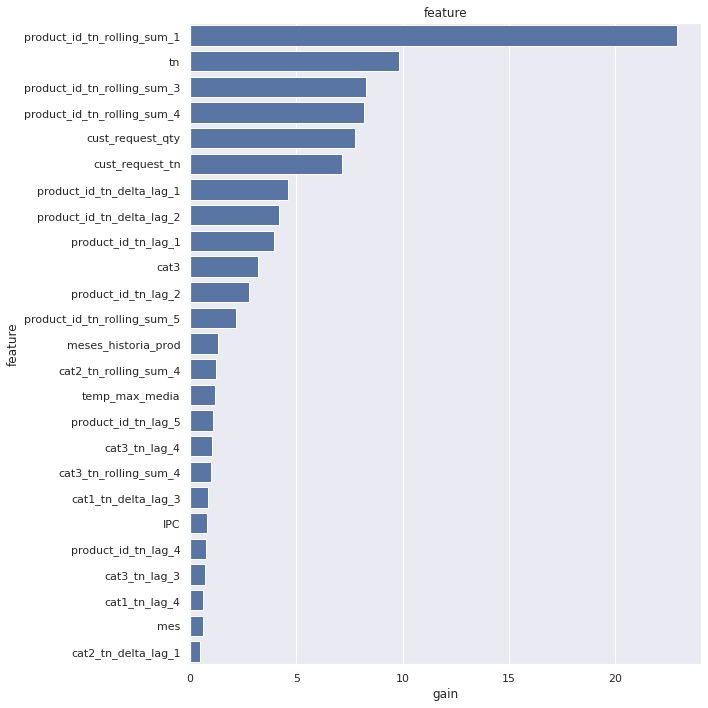

In [21]:
# Feature Importance
best_model_index = study.best_trial.number
best_model = GLOBAL_MODEL_ITER[best_model_index]
feature_importance = lightgbm_aux.plot_lgb_importances(best_model, num=30, plot=True)

In [22]:
#Si se usa holdout, se generan variables para luego evaluar modelos
if(config.USAR_HOLDOUT_PARAM):
    # Dataframes
    df_train_all = df_sellout[(df_sellout.periodo <= config.TRAIN_ALL_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
    df_holdout = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.HOLDOUT_PERIODO_PARAM)]
    
    df_holdout = df_holdout.sort_values(by="product_id",ascending=True)
    print("product_id a testear:", len(df_holdout))

    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    # Variables entrenamiento
    X_train_all = df_train_all.drop(columns=cols_remover_entren, axis=1)
    X_holdout = df_holdout.drop(columns=cols_remover_entren, axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols_entren)

product_id a testear: 780
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905 201906
 201907]
Periodos holdout: [201910]

X_train_all: (29825, 84)
y_train_all: (29825,)

X_holdout: (780, 84)
y_holdout: (780,)


In [23]:
current_datetime = datetime.now().astimezone(pytz.timezone('America/Argentina/Buenos_Aires'))
exp_numero = current_datetime.strftime("%Y%m%d %H%M%S").replace(" ", "_")
exp_numero

'20231215_193408'

In [25]:
# Guardo resultados
carpeta_exp = carpeta_exp_prefijo + exp_numero + "/"
if not os.path.exists(carpeta_exp):
    os.makedirs(carpeta_exp)
    
# Feature Importance
feature_importance.to_csv(carpeta_exp + "feature_importance.csv",index=False)

# Parametros
parametros_nombres = ["PERIODO_INICIO_PARAM","TRAIN_PERIODO_LIMITE_PARAM","VALIDATE_PERIODO_PARAM","USAR_HOLDOUT_PARAM",
                      "TRAIN_ALL_PERIODO_LIMITE_PARAM","HOLDOUT_PERIODO_PARAM",
                      "MODELO_FINAL_PERIODO_LIMITE_PARAM","FUTURE_PERIODO_PARAM",
                      "ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO","ARCH_PRODUCTOS_PREDICCION_FUTURE",
                      "NUM_LAGS_PARAM","FAMILIA_FEATURES_TEMP_PARAM",
                      "CANT_ITERACIONES_OPT_BAY_PARAM","CANT_SEMILLAS"]

parametros_valores = [config.PERIODO_INICIO_PARAM,config.TRAIN_PERIODO_LIMITE_PARAM,config.VALIDATE_PERIODO_PARAM,
                      config.USAR_HOLDOUT_PARAM,config.TRAIN_ALL_PERIODO_LIMITE_PARAM,config.HOLDOUT_PERIODO_PARAM,
                      config.MODELO_FINAL_PERIODO_LIMITE_PARAM,config.FUTURE_PERIODO_PARAM,
                      config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO,config.ARCH_PRODUCTOS_PREDICCION_FUTURE,
                      config.NUM_LAGS_PARAM,config.FAMILIA_FEATURES_TEMP_PARAM,
                      config.CANT_ITERACIONES_OPT_BAY_PARAM, config.CANT_SEMILLAS]

parametros = pd.DataFrame(data={"nombre":parametros_nombres,"valor":parametros_valores})
parametros.to_csv(carpeta_exp + "parametros.csv",index=False)

# Optimizacion Bayesiana
df_opt_bay = pd.DataFrame(data={"lgb_params":GLOBAL_PARAMS_ITER,"best_iteration":GLOBAL_BEST_IT_ITER,
                                "error_rate_validate":GLOBAL_ER_VALIDATE_ITER})

# Ordeno de menor a mayor
df_opt_bay = df_opt_bay.sort_values(by="error_rate_validate",ascending=True)
df_opt_bay["index"] = range(0,len(GLOBAL_PARAMS_ITER))

# Holdout
if(config.USAR_HOLDOUT_PARAM):
    #Seteo vector global
    GLOBAL_PRODUCT_IDS = actualizar_global_prods(X_holdout.product_id,y_holdout)

    
    er_holdout_iter = [None] * len(df_opt_bay)
    er_holdout_semillerio_iter = [None] * len(df_opt_bay)
    
    for i in range(config.OFFSET_EVAL_HOLDOUT,config.CANT_EVAL_HOLDOUT):
        print("Iteración:",i)

        #Modelo Train All (Sin Semillerio)
        model_train_all = lgb.train(df_opt_bay.iloc[i].lgb_params, lgbtrain_all, num_boost_round=df_opt_bay.iloc[i].best_iteration)
        y_pred_holdout = model_train_all.predict(X_holdout)
        er_holdout = metricas.error_rate(y_holdout,y_pred_holdout)
        er_holdout_iter[i]=er_holdout
        
        #Semillerio
        y_pred_holdout_semillerio = lightgbm_aux.semillerio(lgbtrain_all, df_opt_bay.iloc[i].lgb_params, df_opt_bay.iloc[i].best_iteration, X_holdout,config.CANT_SEMILLAS)
        er_holdout_semillerio_iter[i]= metricas.error_rate(y_holdout,y_pred_holdout_semillerio)
        
    df_opt_bay["error_rate_holdout"]=er_holdout_iter    
    df_opt_bay["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    

df_opt_bay.to_excel(carpeta_exp +  "opt_bay.xlsx",index=False)

Iteración: 0
Iteración: 1


IndexError: single positional indexer is out-of-bounds

In [ ]:
print("FINALIZADO")